In [1]:
# Cell: imports
import tensorflow as tf
import numpy as np
from artifactremoval.models import ComplexSpectralModel
from pathlib import Path
import pickle
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

from __future__ import annotations
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as disp

import heapq
from keras_tuner.engine import trial as trial_module

# For reproducibility
tf.random.set_seed(42)
np.random.seed(42)

print("TF version:", tf.__version__)
print("Built with CUDA:", tf.sysconfig.get_build_info().get("cuda_version"))
print("Built with cuDNN:", tf.sysconfig.get_build_info().get("cudnn_version"))
print("GPUs detected by TF:", tf.config.list_physical_devices('GPU'))


TF version: 2.10.0
Built with CUDA: 64_112
Built with cuDNN: 64_8
GPUs detected by TF: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
def load_most_recent_pickle(output_dir, prefix="spectral_train_"):
    # List all matching files
    pickle_files = sorted(
        output_dir.glob(f"{prefix}*.pkl"),
        key=lambda x: x.stat().st_mtime,  # Sort by modification time
        reverse=True  # Most recent first
    )
    
    if not pickle_files:
        raise FileNotFoundError(f"No pickle files found with prefix '{prefix}' in {output_dir}")
    
    most_recent_file = pickle_files[0]
    print(f"Loading most recent file: {most_recent_file.name}")
    
    with open(most_recent_file, "rb") as f:
        data = pickle.load(f)
    
    return data

def build_model(hp):
    # Tunable FC size
    dense_units = hp.Choice("dense_units", [1024, 2048, 4096])

    # Tunable dropout
    dr1 = hp.Float("dropout_rate1", 0.2, 0.3, step=0.025)
    dr2 = hp.Float("dropout_rate2", 0.0, 0.2, step=0.05)

    # Tunable learning‑rate
    lr  = hp.Float("learning_rate", 1e-5, 1e-2, sampling="log")

    model = ComplexSpectralModel().build_main_model(
        dropout_rate1=dr1,
        dropout_rate2=dr2,
        dense_units=dense_units  
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

class MyRandomTuner(kt.RandomSearch):
    def run_trial(self, trial, *fit_args, **fit_kwargs):
        """Override to tune batch_size while keeping Keras‑Tuner happy."""
        hp = trial.hyperparameters
        fit_kwargs["batch_size"] = hp.Choice("batch_size", [32, 64])

        # Add default callbacks / epochs if the user didn't pass them
        fit_kwargs.setdefault(
            "callbacks",
            [tf.keras.callbacks.EarlyStopping("val_loss", patience=3)]
        )
        fit_kwargs.setdefault("epochs", 15)

        # ALWAYS return the result so Tuner can read metrics
        return super().run_trial(trial, *fit_args, **fit_kwargs)
    
class MyBayesTuner(kt.BayesianOptimization):
    def run_trial(self, trial, *args, **kwargs):
        hp = trial.hyperparameters
        kwargs["batch_size"] = hp.Choice("batch_size", [32, 64])
        kwargs.setdefault("epochs", 15)
        kwargs.setdefault("callbacks", [tf.keras.callbacks.EarlyStopping("val_loss", patience=3)])
        return super().run_trial(trial, *args, **kwargs)

In [3]:
base_dir = Path.cwd().parent
input_dir = base_dir / "data" / "ratings" / "aggregate_data"
train_data = load_most_recent_pickle(input_dir, prefix="spectral_train_")

# --- Filter out entries with no consensus_rating ---
filtered = [e for e in train_data if e.get("consensus_rating") is not None]
print(f"Kept {len(filtered)}/{len(train_data)} spectra with valid labels")

# --- Rebuild X and y from the filtered list ---
X = np.stack([e['raw_spectrum'] for e in filtered])
y = np.array([e['consensus_rating'] for e in filtered])

print("Filtered X shape:", X.shape)   # should be (n_valid, 512)
print("Filtered y shape:", y.shape)   # should be (n_valid,)

# (Optional) If your labels are strings, you can encode them numerically:

le = LabelEncoder()
y_encoded = le.fit_transform(y)
print("Classes:", le.classes_)
print("Encoded y shape:", y_encoded.shape)

# Split into train / val / test
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.3, stratify=y, random_state=42)
X_val,   X_test, y_val,   y_test  = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

Loading most recent file: spectral_train_20250423_1640.pkl
Kept 4315/4522 spectra with valid labels
Filtered X shape: (4315, 512)
Filtered y shape: (4315,)
Classes: ['Acceptable' 'Unacceptable']
Encoded y shape: (4315,)


In [5]:
experiment_name = "randomsearch_2"
hyperparam_dir = base_dir / "data" / "hyperparam_tuning"
model_dir = base_dir / "data" / "models"

hyperparam_dir.mkdir(parents=True, exist_ok=True)
model_dir.mkdir(parents=True, exist_ok = True)

# ── 1. search ──────────────────────────────────────
rnd_tuner = MyRandomTuner(
    build_model,
    objective="val_accuracy",
    max_trials=60,
    directory=str(hyperparam_dir),
    project_name=experiment_name,
)

# 2) Launch a brand-new random search
rnd_tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,                        # or however many epochs you like
    # batch_size will be picked by your MyRandomTuner.run_trial(),
    callbacks=[tf.keras.callbacks.EarlyStopping("val_loss", patience=3)]
)

Trial 60 Complete [00h 03m 31s]
val_accuracy: 0.9675425291061401

Best val_accuracy So Far: 0.9768160581588745
Total elapsed time: 03h 26m 27s


In [6]:
# Plot Summary Information from Hyperparameter Tuning

# 1. Harvest tuner results into a DataFrame
records = []
for tr in rnd_tuner.oracle.trials.values():
    hp = tr.hyperparameters.values
    records.append({
        'trial': int(tr.trial_id),
        'val_accuracy': tr.metrics.get_last_value('val_accuracy'),
        'learning_rate': hp.get('learning_rate'),
        'dropout1': hp.get('dropout_rate1'),
        'dropout2': hp.get('dropout_rate2'),
        'batch_size': hp.get('batch_size'),
        'dense_units': hp.get('dense_units'),
    })

df = pd.DataFrame(records).sort_values('trial')


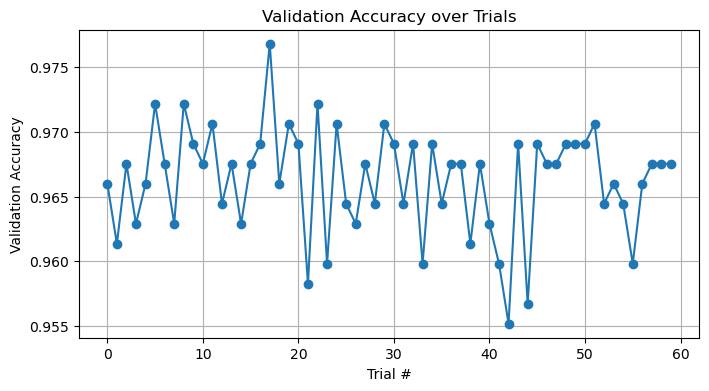

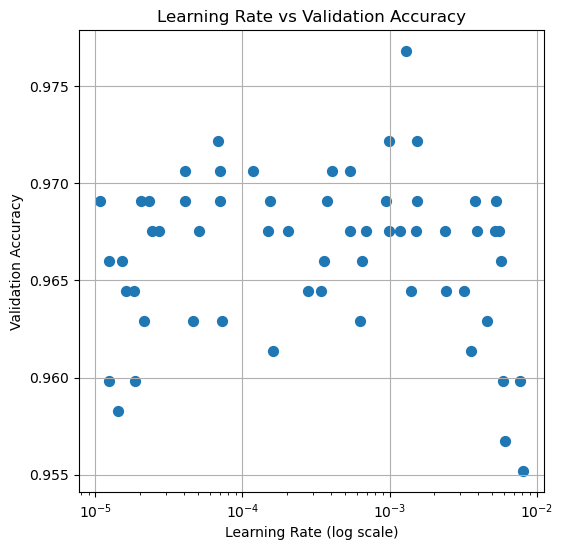

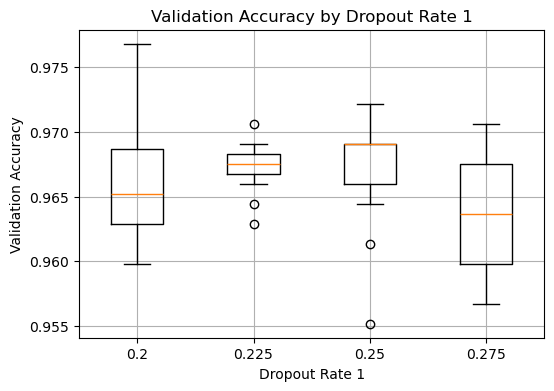

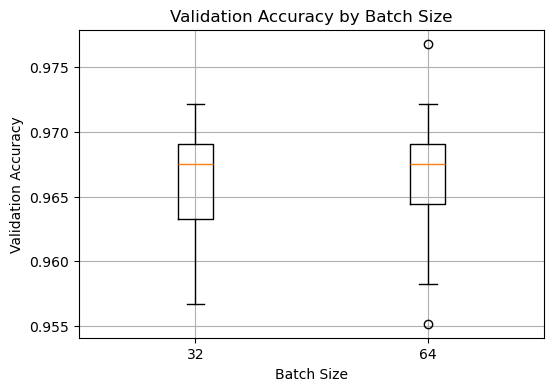

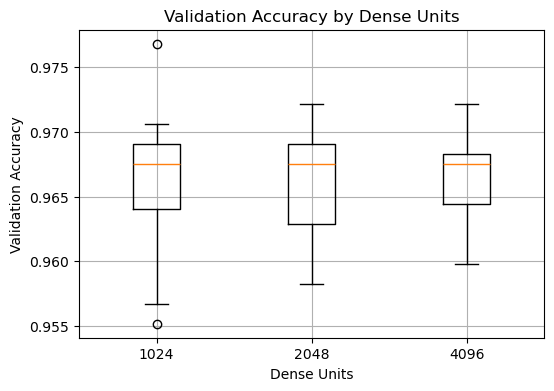

In [7]:

# 2. Progress plot: validation accuracy over trials
plt.figure(figsize=(8, 4))
plt.plot(df['trial'], df['val_accuracy'], marker='o')
plt.title('Validation Accuracy over Trials')
plt.xlabel('Trial #')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.show()

# 3. Scatter: Learning Rate vs. Validation Accuracy
plt.figure(figsize=(6, 6))
plt.scatter(df['learning_rate'], df['val_accuracy'], s=50)
plt.xscale('log')
plt.title('Learning Rate vs Validation Accuracy')
plt.xlabel('Learning Rate (log scale)')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.show()

# 4. Boxplot: Dropout Rate 1 vs. Validation Accuracy
plt.figure(figsize=(6, 4))
drop1_groups = df.groupby('dropout1')['val_accuracy'].apply(list)
plt.boxplot(drop1_groups, tick_labels=drop1_groups.index)
plt.title('Validation Accuracy by Dropout Rate 1')
plt.xlabel('Dropout Rate 1')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.show()

# 5. Boxplot: Batch Size vs. Validation Accuracy
plt.figure(figsize=(6, 4))
bs_groups = df.groupby('batch_size')['val_accuracy'].apply(list)
plt.boxplot(bs_groups, tick_labels=bs_groups.index)
plt.title('Validation Accuracy by Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.show()

# 6. Boxplot: Dense Units vs. Validation Accuracy
plt.figure(figsize=(6, 4))
du_groups = df.groupby('dense_units')['val_accuracy'].apply(list)
plt.boxplot(du_groups, tick_labels=du_groups.index)
plt.title('Validation Accuracy by Dense Units')
plt.xlabel('Dense Units')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.show()



In [8]:
# Sort by validation accuracy, descending, and grab the top 10
df_best = df.sort_values("val_accuracy", ascending=False).head(10)

# 1. Define formatting: only learning_rate in exponential form, others rounded
fmt = {
    'learning_rate': '{:.1e}',  # e.g. 3.6e-04
    'val_accuracy': '{:.3f}',   # three decimals
    'dropout_rate1': '{:.3f}',
    'dropout_rate2': '{:.3f}',
    'batch_size': '{:.0f}',     # integer
    'dense_units': '{:.0f}',
}

# 2. Render with pandas Styler
(df_best
    .style
    .format(fmt)
    .set_caption("Top 10 Hyperparameter Trials")
    .hide(axis = "index")
)


trial,val_accuracy,learning_rate,dropout1,dropout2,batch_size,dense_units
17,0.977,1.3e-03,0.200000,0.050000,64,1024
5,0.972,6.8e-05,0.250000,0.000000,32,4096
22,0.972,1.5e-03,0.250000,0.150000,64,2048
8,0.972,1.0e-03,0.200000,0.000000,64,4096
24,0.971,4.1e-05,0.250000,0.150000,32,2048
51,0.971,5.4e-04,0.250000,0.000000,64,1024
19,0.971,1.2e-04,0.275000,0.200000,32,1024
11,0.971,4.0e-04,0.250000,0.000000,32,1024
29,0.971,7.0e-05,0.225000,0.050000,32,4096
30,0.969,4.1e-05,0.250000,0.000000,64,4096


In [9]:
# 1) Reload your completed random-search tuner
rnd_tuner = MyRandomTuner(
    build_model,
    objective="val_accuracy",
    max_trials=60,
    directory=str(hyperparam_dir),
    project_name="randomsearch_2",
)
rnd_tuner.reload()

# 2) Collect top-10 (score, HyperParameters)
def trial_tuples(tuner):
    for tr in tuner.oracle.trials.values():
        yield (tr.metrics.get_last_value("val_accuracy"), tr.hyperparameters)
best_10 = heapq.nlargest(10, trial_tuples(rnd_tuner), key=lambda x: x[0])

# 3) Instantiate the Bayesian tuner (no search yet!)
bayes_tuner = MyBayesTuner(
    build_model,
    objective="val_accuracy",
    max_trials=40,          # total new BO trials (incl. your seeded 10)
    num_initial_points=0,   # skip random warm-up
    directory=str(hyperparam_dir),
    project_name="bayes_narrowed",
)

# 4) Seed the Oracle *before* any search
for score, hp in best_10:
    tr = bayes_tuner.oracle.create_trial(bayes_tuner.tuner_id)
    tr.hyperparameters.values = hp.values.copy()
    tr.status = trial_module.TrialStatus.COMPLETED
    bayes_tuner.oracle.update_trial(
        trial_id=tr.trial_id,
        metrics={"val_accuracy": score},
        step=1,
    )
    bayes_tuner.oracle.end_trial(tr.trial_id, tr.status)

# 5) Now run the BO search *once*
bayes_tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    # let MyBayesTuner.run_trial pick batch_size
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=5, restore_best_weights=True
        )
    ],
)

# 6) Finally, inspect the best
best_bayes_hps = bayes_tuner.get_best_hyperparameters(1)[0]
print("Best Bayesian LR      :", best_bayes_hps.get("learning_rate"))
print("Best Bayesian Dropout1:", best_bayes_hps.get("dropout_rate1"))
print("Best Bayesian Dropout2:", best_bayes_hps.get("dropout_rate2"))
print("Best Bayesian Batch   :", best_bayes_hps.get("batch_size"))
print("Best Bayesian Units   :", best_bayes_hps.get("dense_units"))

Trial 40 Complete [00h 04m 24s]
val_accuracy: 0.9675425291061401

Best val_accuracy So Far: 0.9783616662025452
Total elapsed time: 02h 11m 25s
Best Bayesian LR      : 4.2438197664657357e-05
Best Bayesian Dropout1: 0.2
Best Bayesian Dropout2: 0.05
Best Bayesian Batch   : 32
Best Bayesian Units   : 4096


In [12]:
# Plot Summary Information from Hyperparameter Tuning

# 1. Harvest tuner results into a DataFrame
records = []
for tr in bayes_tuner.oracle.trials.values():
    hp = tr.hyperparameters.values
    records.append({
        'trial': int(tr.trial_id),
        'val_accuracy': tr.metrics.get_last_value('val_accuracy'),
        'learning_rate': hp.get('learning_rate'),
        'dropout1': hp.get('dropout_rate1'),
        'dropout2': hp.get('dropout_rate2'),
        'batch_size': hp.get('batch_size'),
        'dense_units': hp.get('dense_units'),
    })

df_bayes = pd.DataFrame(records).sort_values('trial')

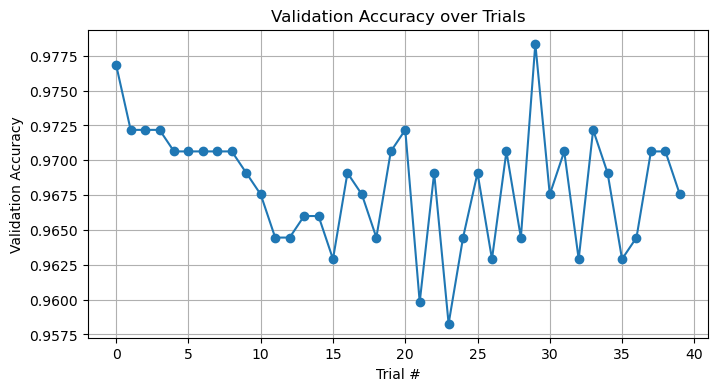

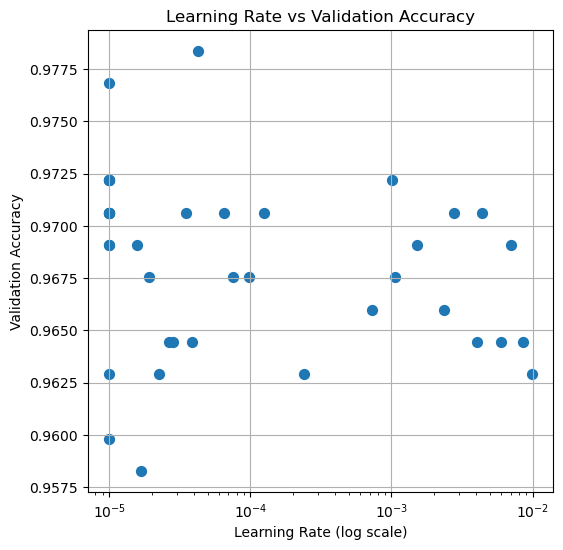

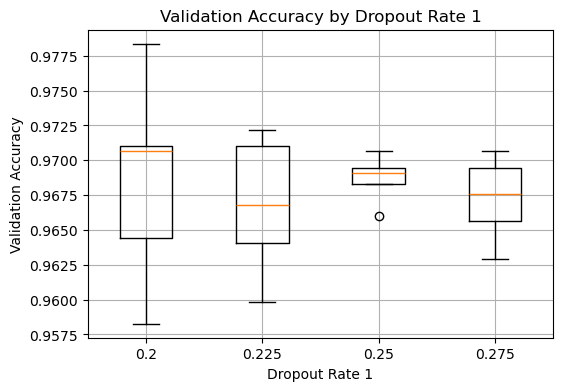

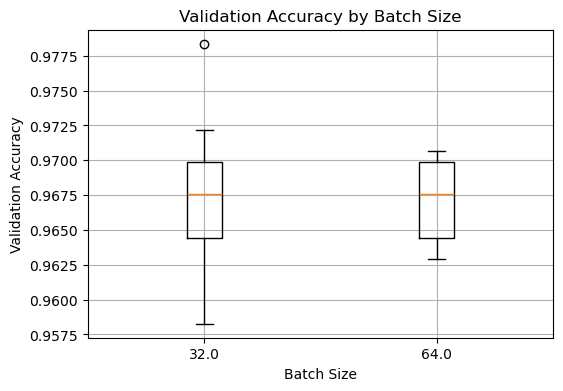

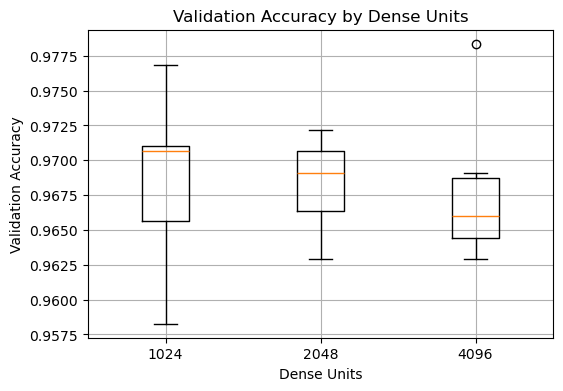

In [ ]:

# 2. Progress plot: validation accuracy over trials
plt.figure(figsize=(8, 4))
plt.plot(df_bayes['trial'], df_bayes['val_accuracy'], marker='o')
plt.title('Validation Accuracy over Trials')
plt.xlabel('Trial #')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.show()

# 3. Scatter: Learning Rate vs. Validation Accuracy
plt.figure(figsize=(6, 6))
plt.scatter(df_bayes['learning_rate'], df_bayes['val_accuracy'], s=50)
plt.xscale('log')
plt.title('Learning Rate vs Validation Accuracy')
plt.xlabel('Learning Rate (log scale)')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.show()

# 4. Boxplot: Dropout Rate 1 vs. Validation Accuracy
plt.figure(figsize=(6, 4))
drop1_groups = df_bayes.groupby('dropout1')['val_accuracy'].apply(list)
plt.boxplot(drop1_groups, tick_labels=drop1_groups.index)
plt.title('Validation Accuracy by Dropout Rate 1')
plt.xlabel('Dropout Rate 1')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.show()

# 5. Boxplot: Batch Size vs. Validation Accuracy
plt.figure(figsize=(6, 4))
bs_groups = df_bayes.groupby('batch_size')['val_accuracy'].apply(list)
plt.boxplot(bs_groups, tick_labels=bs_groups.index)
plt.title('Validation Accuracy by Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.show()

# 6. Boxplot: Dense Units vs. Validation Accuracy
plt.figure(figsize=(6, 4))
du_groups = df_bayes.groupby('dense_units')['val_accuracy'].apply(list)
plt.boxplot(du_groups, tick_labels=du_groups.index)
plt.title('Validation Accuracy by Dense Units')
plt.xlabel('Dense Units')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.show()